## Keras implementation of https://junyanz.github.io/CycleGAN/

In [1]:
import os
os.environ['KERAS_BACKEND']='tensorflow' # can choose theano, tensorflow, cntk
os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_run,dnn.library_path=/usr/lib'
#os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_compile,dnn.library_path=/usr/lib'

In [2]:
import keras.backend as K
if os.environ['KERAS_BACKEND'] =='theano':
    channel_axis=1
    K.set_image_data_format('channels_first')
    channel_first = True
else:
    K.set_image_data_format('channels_last')
    channel_axis=-1
    channel_first = False

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal

In [4]:
# Weights initializations
# bias are initailized as 0
def __conv_init(a):
    print("conv_init", a)
    k = RandomNormal(0, 0.02)(a) # for convolution kernel
    k.conv_weight = True    
    return k
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02) # for batch normalization


In [5]:
# HACK speed up theano
if K._BACKEND == 'theano':
    import keras.backend.theano_backend as theano_backend
    def _preprocess_conv2d_kernel(kernel, data_format):
        #return kernel
        if hasattr(kernel, "original"):
            print("use original")
            return kernel.original
        elif hasattr(kernel, '_keras_shape'):
            s = kernel._keras_shape
            print("use reshape",s)
            kernel = kernel.reshape((s[3], s[2],s[0], s[1]))
        else:
            kernel = kernel.dimshuffle((3, 2, 0, 1))
        return kernel
    theano_backend._preprocess_conv2d_kernel = _preprocess_conv2d_kernel

In [6]:
# Basic discriminator
def conv2d(f, *a, **k):
    return Conv2D(f, kernel_initializer = conv_init, *a, **k)
def batchnorm():
    return BatchNormalization(momentum=0.9, axis=channel_axis, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)
def BASIC_D(nc_in, ndf, max_layers=3, use_sigmoid=True):
    """DCGAN_D(nc, ndf, max_layers=3)
       nc: channels
       ndf: filters of the first layer
       max_layers: max hidden layers
    """    
    if channel_first:
        input_a =  Input(shape=(nc_in, None, None))
    else:
        input_a = Input(shape=(None, None, nc_in))
    _ = input_a
    _ = conv2d(ndf, kernel_size=4, strides=2, padding="same", name = 'First') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    
    for layer in range(1, max_layers):        
        out_feat = ndf * min(2**layer, 8)
        _ = conv2d(out_feat, kernel_size=4, strides=2, padding="same", 
                   use_bias=False, name = 'pyramid.{0}'.format(layer)             
                        ) (_)
        _ = batchnorm()(_, training=1)        
        _ = LeakyReLU(alpha=0.2)(_)
    
    out_feat = ndf*min(2**max_layers, 8)
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(out_feat, kernel_size=4,  use_bias=False, name = 'pyramid_last') (_)
    _ = batchnorm()(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)
    
    # final layer
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(1, kernel_size=4, name = 'final'.format(out_feat, 1), 
               activation = "sigmoid" if use_sigmoid else None) (_)    
    return Model(inputs=[input_a], outputs=_)

In [7]:
def UNET_G(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True):    
    max_nf = 8*ngf    
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(nf_next, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'conv_{0}'.format(s)) (x)
        if s>2:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s//2, nf_next)
            x = Concatenate(axis=channel_axis)([x, x2])            
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=4, strides=2, use_bias=not use_batchnorm,
                            kernel_initializer = conv_init,          
                            name = 'convt.{0}'.format(s))(x)        
        x = Cropping2D(1)(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s <=8:
            x = Dropout(0.5)(x, training=1)
        return x
    
    s = isize if fixed_input_size else None
    if channel_first:
        _ = inputs = Input(shape=(nc_in, s, s))
    else:
        _ = inputs = Input(shape=(s, s, nc_in))        
    _ = block(_, isize, nc_in, False, nf_out=nc_out, nf_next=ngf)
    _ = Activation('tanh')(_)
    return Model(inputs=inputs, outputs=[_])

In [8]:
nc_in = 3
nc_out = 3
ngf = 64
ndf = 64
use_lsgan = True
lambdavar = 10 if use_lsgan else 100

loadSize = 256#143
imageSize = 256#128
batchSize = 1
lrD = 2e-4
lrG = 2e-4

In [9]:
netDA = BASIC_D(nc_in, ndf, use_sigmoid = not use_lsgan)
netDB = BASIC_D(nc_out, ndf, use_sigmoid = not use_lsgan)
netDA.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
First (Conv2D)               (None, None, None, 64)    3136      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, None, None, 64)    0         
_________________________________________________________________
pyramid.1 (Conv2D)           (None, None, None, 128)   131072    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 128)   512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, None, None, 128)   0         
_________________________________________________________________
pyramid.2 (Conv2D)           (None, None, None, 256)   524288    
__________

In [10]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


netGB = UNET_G(imageSize, nc_in, nc_out, ngf)
netGA = UNET_G(imageSize, nc_out, nc_in, ngf)
#SVG(model_to_dot(netG, show_shapes=True).create(prog='dot', format='svg'))
netGA.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv_256 (Conv2D)               (None, 128, 128, 64) 3136        input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_16 (LeakyReLU)      (None, 128, 128, 64) 0           conv_256[0][0]                   
__________________________________________________________________________________________________
conv_128 (Conv2D)               (None, 64, 64, 128)  131072      leaky_re_lu_16[0][0]             
__________________________________________________________________________________________________
batch_norm

In [11]:
from keras.optimizers import RMSprop, SGD, Adam

In [12]:
if use_lsgan:
    loss_fn = lambda output, target : K.mean(K.abs(K.square(output-target)))
else:
    loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))

def cycle_variables(netG1, netG2):
    real_input = netG1.inputs[0]
    fake_output = netG1.outputs[0]
    rec_input = netG2([fake_output])
    fn_generate = K.function([real_input], [fake_output, rec_input])
    return real_input, fake_output, rec_input, fn_generate

real_A, fake_B, rec_A, cycleA_generate = cycle_variables(netGB, netGA)
real_B, fake_A, rec_B, cycleB_generate = cycle_variables(netGA, netGB)

In [13]:
def D_loss(netD, real, fake, rec):
    output_real = netD([real])
    output_fake = netD([fake])
    loss_D_real = loss_fn(output_real, K.ones_like(output_real))
    loss_D_fake = loss_fn(output_fake, K.zeros_like(output_fake))
    loss_G = loss_fn(output_fake, K.ones_like(output_fake))
    loss_D = loss_D_real+loss_D_fake
    loss_cyc = K.mean(K.abs(rec-real))
    return loss_D, loss_G, loss_cyc

loss_DA, loss_GA, loss_cycA = D_loss(netDA, real_A, fake_A, rec_A)
loss_DB, loss_GB, loss_cycB = D_loss(netDB, real_B, fake_B, rec_B)
loss_cyc = loss_cycA+loss_cycB

In [14]:
loss_G = loss_GA+loss_GB+lambdavar*loss_cyc
loss_D = loss_DA+loss_DB

weightsD = netDA.trainable_weights + netDB.trainable_weights
weightsG = netGA.trainable_weights + netGB.trainable_weights

training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(weightsD,[],loss_D)
netD_train = K.function([real_A, real_B],[loss_DA/2, loss_DB/2], training_updates)
training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(weightsG,[], loss_G)
netG_train = K.function([real_A, real_B], [loss_GA, loss_GB, loss_cyc], training_updates)

In [15]:
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle

def load_data(file_pattern):
    return glob.glob(file_pattern)

def read_image(fn):
    im = Image.open(fn).convert('RGB')
    im = im.resize( (loadSize, loadSize), Image.BILINEAR )
    arr = np.array(im).astype(float)
    arr=arr/255*2-1
    
    w1,w2 = (loadSize-imageSize)//2,(loadSize+imageSize)//2
    h1,h2 = w1,w2
    img = arr[h1:h2, w1:w2, :]
    if randint(0,1):
        img=img[:,::-1]
    if channel_first:        
        img = np.moveaxis(img, 2, 0)
    return img

#data = "edges2shoes"
#data = "horse2zebra"
#data = "celebrityToSim"
#data = "human2animal"
data = "Dan2Dali"
Dan_NUM = 38-1
Dali_NUM = 139-1
train_A = load_data('datasets/{}/trainA/*.png'.format(data))
train_B = load_data('datasets/{}/trainB/*.jpg'.format(data))

assert len(train_A) and len(train_B)

In [16]:
import random
def minibatch_(data, batchsize, pic_number):
    length = len(data)
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            #shuffle(data)
            #i = 0
            i = random.randint(1, pic_number)
            epoch+=1        
        rtn = [read_image(data[j]) for j in range(i,i+size)]
        i+=size
        tmpsize = yield epoch, np.float32(rtn), i       

def minibatchAB(dataA, dataB, batchsize):
    batchA=minibatch_(dataA, batchsize, Dan_NUM)
    batchB=minibatch_(dataB, batchsize, Dali_NUM)
    tmpsize = None    
    while True:        
        ep1, A, indexA = batchA.send(tmpsize)
        ep2, B, indexB = batchB.send(tmpsize)
        tmpsize = yield max(ep1, ep2), A, B, indexA, indexB

In [17]:
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1,3,imageSize,imageSize), 1, 3)
    else:
        int_X = int_X.reshape(-1,imageSize,imageSize, 3)
    int_X = int_X.reshape(rows, -1, imageSize, imageSize,3).swapaxes(1,2).reshape(rows*imageSize,-1, 3)
    display(Image.fromarray(int_X))

In [18]:
def saveX(X, Painter, image, epoch, gen_iterations, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1,3,imageSize,imageSize), 1, 3)
    else:
        int_X = int_X.reshape(-1,imageSize,imageSize, 3)
    int_X = int_X.reshape(rows, -1, imageSize, imageSize,3).swapaxes(1,2).reshape(rows*imageSize,-1, 3)
    saveImage = Image.fromarray(int_X)
    print("int_X = ", int_X.shape)
    if(Painter == 'Dan'):
        saveImage.save('results/Dan/Dan2Dali_{}_{}_{}.jpeg'.format(image, epoch, gen_iterations))

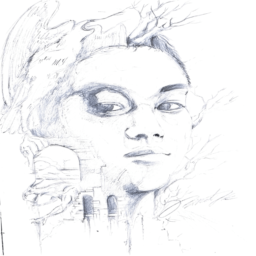

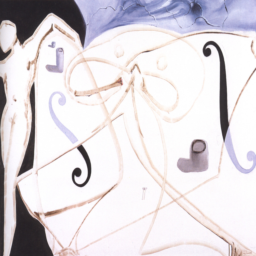

In [19]:
#train_batch = minibatchAB(train_A, train_B, 6)
train_batch = minibatchAB(train_A, train_B, 1)

_, A, B, indexA, indexB = next(train_batch)
showX(A)
showX(B)
#del train_batch, A, B

In [20]:
def showG(A,B,index,epoch,gen_iterations):
    assert A.shape==B.shape
    def G(fn_generate, X):
        r = np.array([fn_generate([X[i:i+1]]) for i in range(X.shape[0])])
        return r.swapaxes(0,1)[:,:,0]        
    rA = G(cycleA_generate, A)
    rB = G(cycleB_generate, B)
    saveX(rA[0], 'Dan', index, epoch, gen_iterations, rows=1)
    arr = np.concatenate([A,B,rA[0],rB[0],rA[1],rB[1]])
    showX(arr, 3)

[150/150][1405] Loss_D: 0.205872 0.233400 Loss_G: 1.170808 0.262057 loss_cyc 0.167928 1304.4604580402374
indexA= 7
indexB= 63
int_X =  (256, 256, 3)


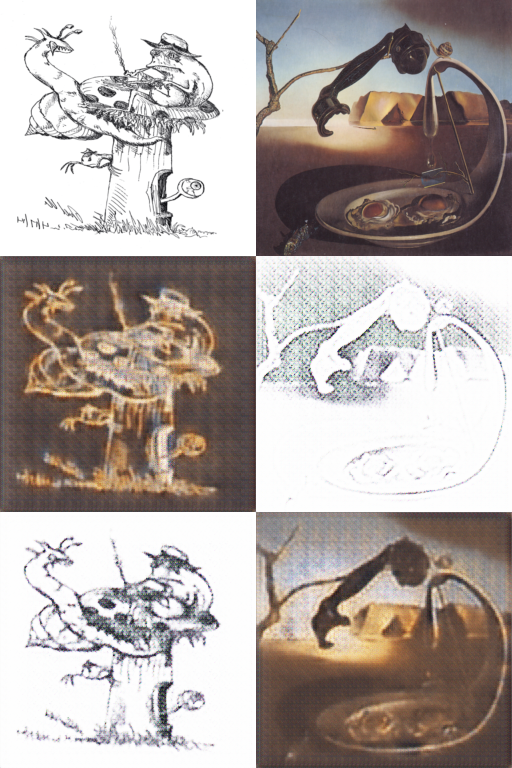

In [21]:
import time
from IPython.display import clear_output
t0 = time.time()
niter = 150
gen_iterations = 0
epoch = 0
errCyc_sum = errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0

#display_iters = 50
display_iters = 1
#val_batch = minibatch(valAB, 6, direction)
train_batch = minibatchAB(train_A, train_B, batchSize)

print("train_A.size = ", len(train_A))
print("train_B.size = ", len(train_B))


while epoch < niter: 
    epoch, A, B, indexA, indexB = next(train_batch)        
    errDA, errDB  = netD_train([A, B])
    errDA_sum +=errDA
    errDB_sum +=errDB

    # epoch, trainA, trainB = next(train_batch)
    errGA, errGB, errCyc = netG_train([A, B])
    errGA_sum += errGA
    errGB_sum += errGB
    errCyc_sum += errCyc
    gen_iterations+=1
    if gen_iterations%display_iters==0:
        #if gen_iterations%(5*display_iters)==0:
        clear_output()
        print('[%d/%d][%d] Loss_D: %f %f Loss_G: %f %f loss_cyc %f'
        % (epoch, niter, gen_iterations, errDA_sum/display_iters, errDB_sum/display_iters,
           errGA_sum/display_iters, errGB_sum/display_iters, 
           errCyc_sum/display_iters), time.time()-t0)
        #_, A, B, indexA, indexB = train_batch.send(4)
        #_, A, B, indexA, indexB = train_batch.send(1)
        _, A, B, indexA, indexB = train_batch.send(1)
        #print("indexA=",indexA)
        #print("indexB=",indexB)        
        showG(A,B,indexA,epoch,gen_iterations)
        errCyc_sum = errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0